**Mangrove monitoring using multitemporal Sentinel-2 SR and Mangrove Vegetation Index**

In [ ]:
"""
Mangrove Vegetation Index (MVI) citation:

Baloloy, A.B., Blanco, A.C., Ana, R.R.C.S., Nadaoka, K., 2020,
Development and application of a new mangrove vegetation index (MVI) for rapid and accurate mangrove mapping,
ISPRS Journal of Photogrammetry and Remote Sensing, Vol. 166, pp. 95-117.
https://doi.org/10.1016/j.isprsjprs.2020.06.001
"""

In [1]:
import ee

In [2]:
ee.Authenticate()

In [3]:
# Initialize your Earth Engine cloud project

ee.Initialize(project='ee-yourproject')

Mounted at /content/drive


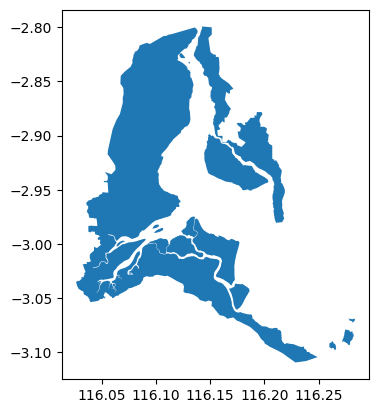

In [4]:
# Access google drive and open a shapefile

import geopandas as gpd
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Replace 'path/to/your/shapefile.shp' with the actual path to your shapefile in Google Drive
shapefile_path = '/content/drive/My Drive/Your_folder/Your_shapefile.shp'

# Open shapefile using Geopandas
try:
    gdf = gpd.read_file(shapefile_path)
    gdf.plot()
except FileNotFoundError:
    print(f"Error: Shapefile not found at {shapefile_path}")
except Exception as e:
    print(f"An error occurred: {e}")

In [5]:
# Converting shapefile into Earth Engine geometry

import json

region_js = json.loads(gdf.to_json())
region_fc = ee.FeatureCollection(region_js)
region = ee.Geometry(region_fc.geometry())

In [6]:
# Region center

region_center = region.centroid().coordinates().getInfo()
print(region_center)

[116.1186604102572, -2.9461974517515026]


In [7]:
# Determining parameters

num_years = 6
last_year = 2024

start_date = []
end_date = []
years = []

for i in range(num_years):
    year = last_year - num_years + i + 1
    start_date.append(f'{year}-01-01')
    end_date.append(f'{year}-12-31')
    years.append(year)

print(start_date)
print(end_date)
print(years)

['2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01']
['2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31', '2024-12-31']
[2019, 2020, 2021, 2022, 2023, 2024]


In [8]:
# Access multitempiral Sentinel-2 surface reflectance

s2_col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

s2_image_list = []

for i in range(num_years):
  dataset = s2_col.filterBounds(region) \
      .filterDate(start_date[i], end_date[i]) \
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
  s2_image_list.append(dataset.median())

In [9]:
# Calculate multitemporal Mangrove Vegetation Index (MVI)
# Creating mangrove extent image

mvi_list = []

for i in range(num_years):
  green = s2_image_list[i].select('B3')
  nir = s2_image_list[i].select('B8')
  swir1 = s2_image_list[i].select('B11')
  mvi = (nir.subtract(green)).divide(swir1.subtract(green))
  mask = mvi.gte(4.5).And(mvi.lte(16.5))
  mvi = mvi.updateMask(mask)
  mvi = mvi.clip(region)
  mvi_list.append(mvi)

In [10]:
# Create geemap MVI timeseries

import geemap

# Create a list of dates corresponding to the MVI images
dates = [f'{year}' for year in years]  # Or use actual dates if available

# Visualization parameters
vis_params = {
    'min': 4.5,
    'max': 16.5,
    'palette': ['seagreen', 'darkgreen', 'darkblue']
}

# Create the MVI time series visualization using geemap
Map = geemap.Map(basemap='Esri.WorldTopoMap')
Map.centerObject(region, 11)

# Create image collection from image list
mvi_col = ee.ImageCollection.fromImages(mvi_list)

# Create labels
labels = [str(year) for year in years]

# Add a layer control panel
Map.add_time_slider(mvi_col, vis_params, labels=labels, time_interval=1)

# Display the map
Map

Map(center=[-2.9461974517515026, 116.1186604102572], controls=(WidgetControl(options=['position', 'transparent…